## Quantum Layers Application

In [5]:
#Import the required modules
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split


## Convolutional Layers 1 - From different Paper

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(a[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(a[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(a[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     ├──────────┤└────┬────┘└────┬────┘                      
q_3: ┤ Rx(a[3]) ├─────■──────────■───────────────────────────
     └──────────┘                                            


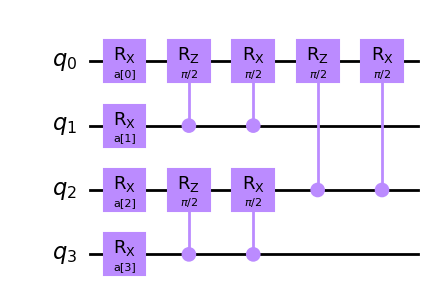

In [6]:
def conv_circuit(params):
    target = QuantumCircuit(4)
    #Apqmly the Rx gate with given parameteres
    for i in range(len(params)):
        target.rx(params[i],i)
    #Assuming that the gates without the angle are rotated by pi/2
    target.crz(np.pi / 2, 1, 0)
    target.crx(np.pi / 2, 1, 0)
    target.crz(np.pi/2, 3, 2) #Apply controlled Rz to 3rd and 4
    target.crx(np.pi/2 , 3, 2)
    target.crz(np.pi/2 , 2, 0)
    target.crx(np.pi/2, 2, 0 )
    print(target)
    return target

params = ParameterVector("a",length = 4)
circuit = conv_circuit(params)
circuit.draw("mpl")

    
    

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ─────────────────■──────────■───────────────────────────
                                                             
     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[3]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[4]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[5]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ───

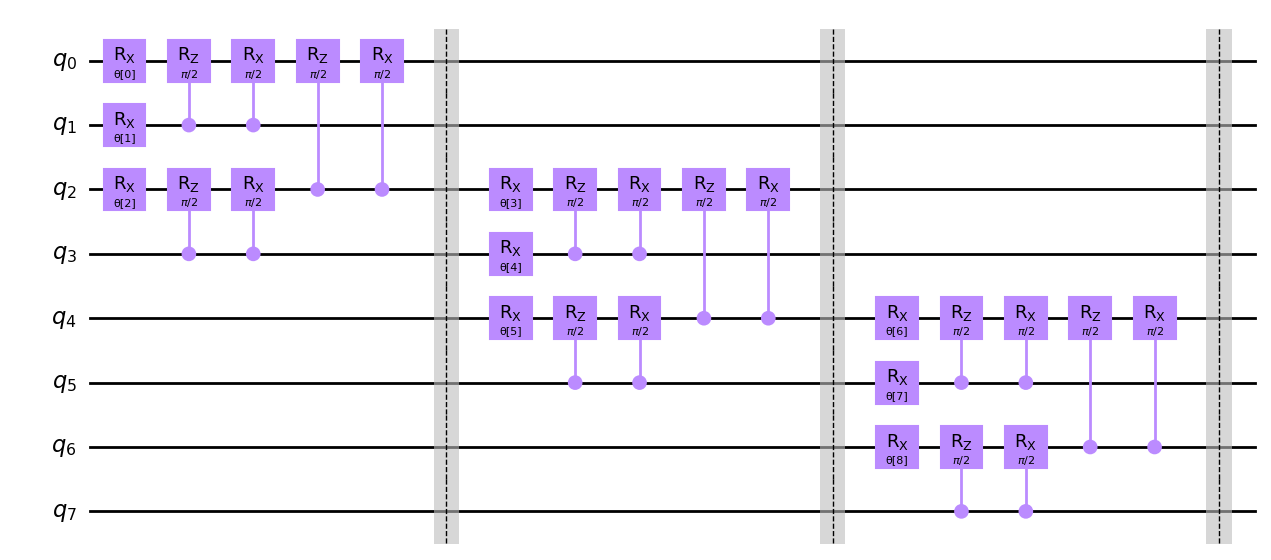

In [7]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)

    for i in range(0, num_qubits - 3, 2):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), qubits[i : i + 4])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl")

### Testing New Convolutional Layer

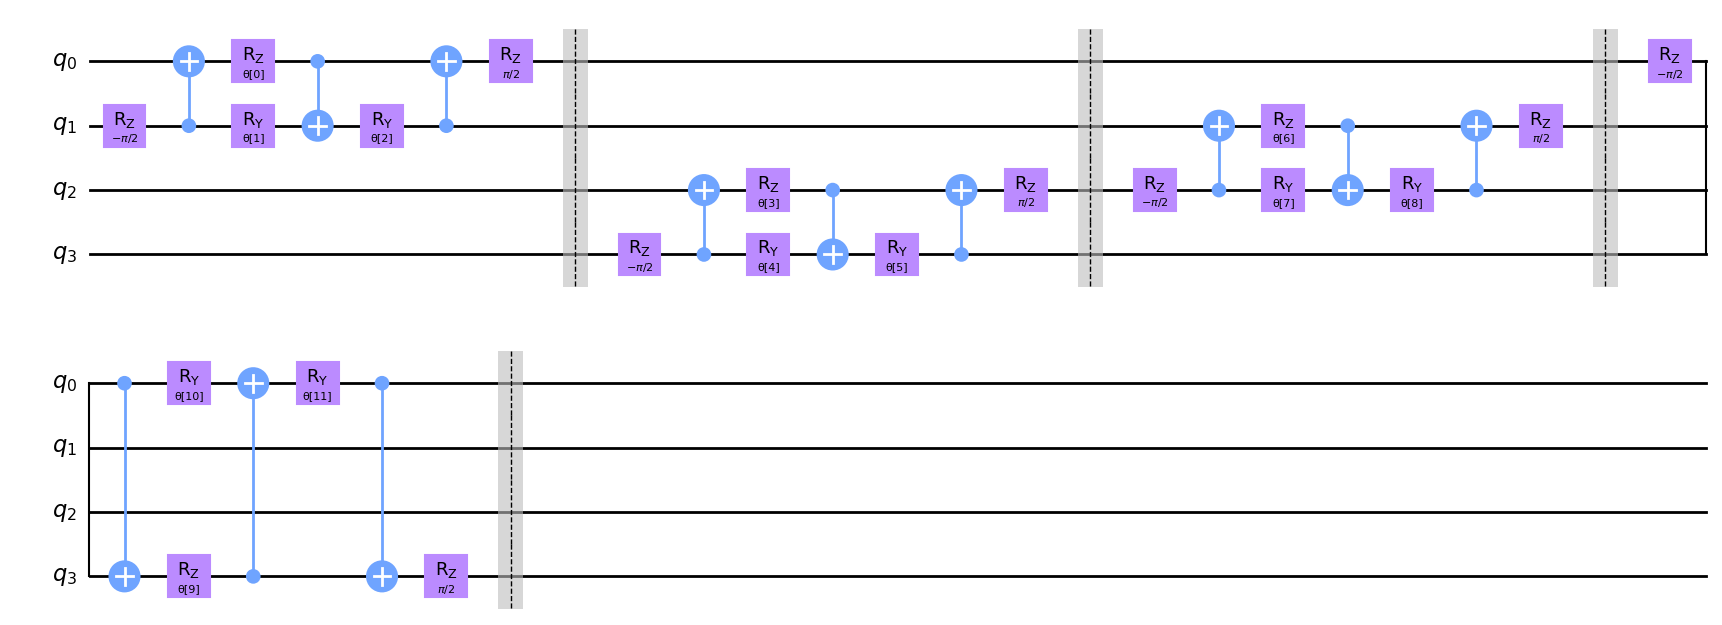

In [8]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")


## Pooling Layers

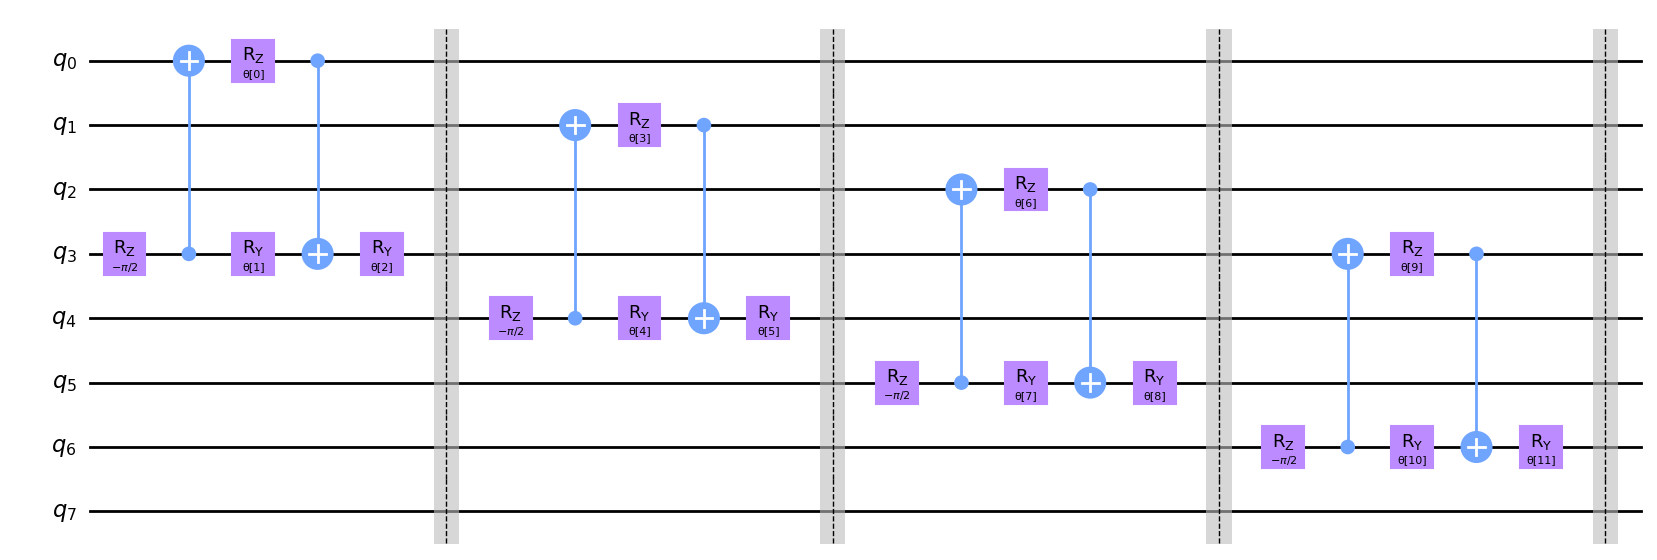

In [9]:

#Defining a single pooling layer
def pooling_circuit(params) :
    target = QuantumCircuit(2)          #We are defining a quantum circuit with 2 qubits
    target.rz(-np.pi / 2,1)             #Applying the Rz gate to the qubit at position 1
    target.cx(1,0)                      #Apply CNOT gate with second qubit as control and first qubit as control
    target.rz(params[0], 0)             #Apply a rotation angle stored in params[0] to qubit in position 0
    target.ry(params[1],1)
    target.cx(0,1)
    target.ry(params[2],1)

    return target

#Define the layer  for a larger number of qubits
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks) #The number of qubits is equal to the total number of sources and sinks. Sources are original qubits and sinks are qubits after pooling
    qc = QuantumCircuit(num_qubits, name = "Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length = num_qubits // 2*3) #We divide num_qubits by 2 as we need a parameter vector for each pair of source and sinks. 
    # The number of paramters is 3 as we use the 3 of them in the pooling_circuit code. The params array contain a rotation angle for X, Y and Z axis. Hence size is 3

    for source, sink in zip(sources, sinks):
        qc = qc.compose(pooling_circuit(params[param_index : (param_index + 3)]), [source, sink]) #The first three parameters are sent to compose the circuit on the source and sink
        qc.barrier()
        param_index+=3 #Switch to the next set of 3 parameters after first layer
    
    qc_inst = qc.to_instruction() #Convert the quantum circuit into a single instruction to add to other circuits
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc # Return the quantum circuit


sources = [0,1, 2,3]
sinks = [3, 4,5,6]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

## Generating the dataset in the same way

In [10]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6,8))
    ver_array = np.zeros((4,8))
    j = 0
    for i in range(0,7):
        if i !=3:
            hor_array[j][i] = np.pi/2
            hor_array[j][i+1] = np.pi/2
            j+=1
    j =0
    for i in range(0,4):
        ver_array[j][i] = np.pi/2
        ver_array[j][i+4] = np.pi/2
        j+=1
    
    for n in range(num_images):
        rng = algorithm_globals.random.integers(0,2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0,6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0,4)
            images.append(np.array(ver_array[random_image]))
        
        #noise generation
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi/4)
        
    return images,labels


In [11]:
images, labels = generate_dataset(150)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

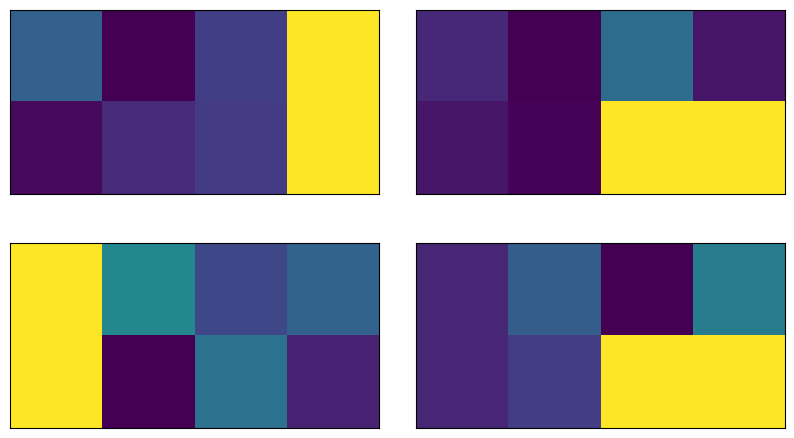

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2,4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

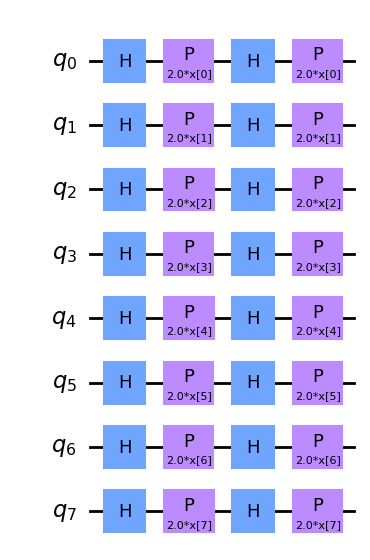

In [13]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

## Testing Data Encoding written by us

In [14]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute

norm = 0
size = 0

def encode(dataset):
    global norm, size
    size = len(dataset)
    print(dataset)
    print(len(dataset))

    # Calculate the number of qubits needed to encode the values
    num_qubits = int(np.ceil(np.log2(len(dataset))))
    qc = QuantumCircuit(num_qubits)

    # Initialize the quantum circuit to the desired state
    norm = np.linalg.norm(dataset)
    desired_state = dataset / norm
    desired_state = np.pad(desired_state, (0, 2 ** num_qubits - len(desired_state)), mode='constant', constant_values=0)
    qc.initialize(desired_state, list(range(num_qubits)))

    # Return the quantum circuit
    return qc

def decode(qc):
    global norm, size
    
    shots = 1000000

    # Measure the quantum circuit
    qc.measure_all()
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Use the counts to estimate the values
    decoded = np.zeros(size)
    for i, j in counts.items():
        decoded[int(i, 2)] = round((j / shots) ** 0.5 * norm)
    
    return decoded

## Training

In [35]:

feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
print(f"Number of parameters is: {len(circuit.parameters)}")

Number of parameters is: 71


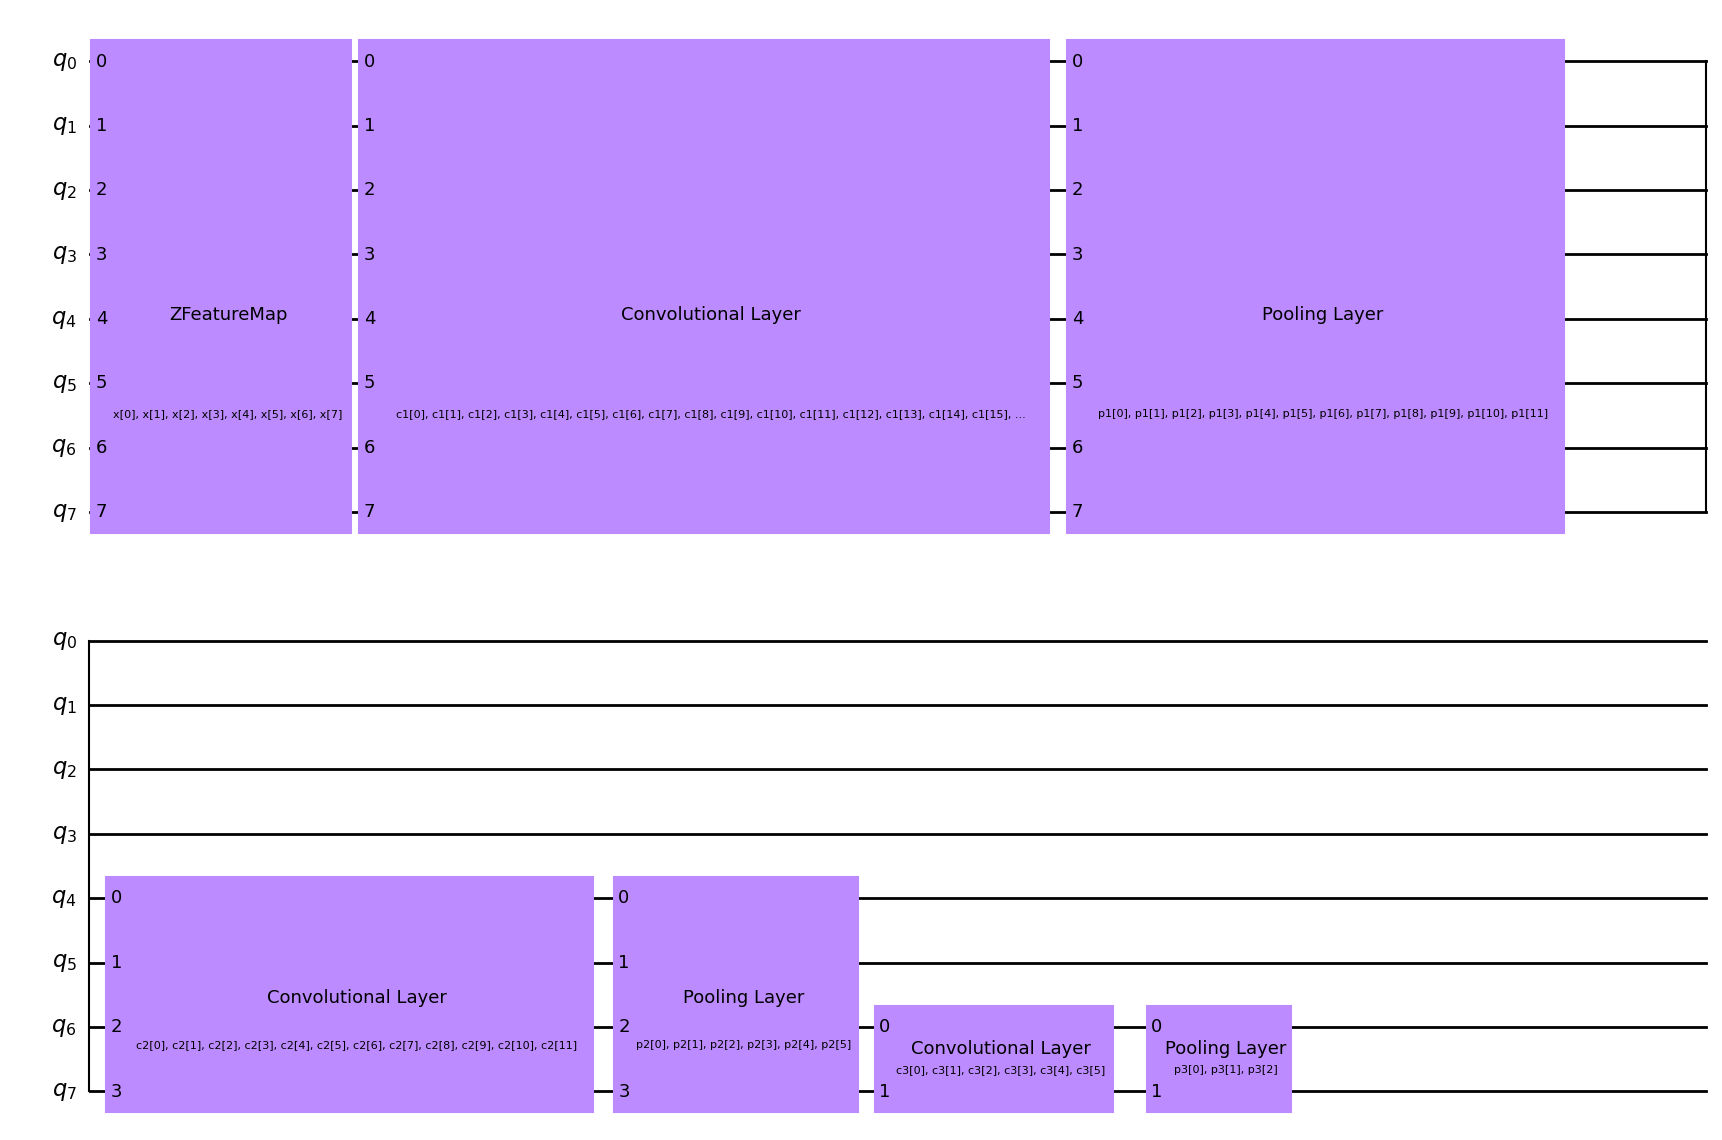

In [16]:
circuit.draw("mpl")

In [36]:
circuitQNG = circuit
print(f"Number of parameters is: {len(circuit.parameters)}")

Number of parameters is: 71


In [18]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [19]:
initial_point = np.random.rand(63) #24 = 8*3

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

## Possible VQE Implementation instead of COBYLA

In [20]:
from qiskit import QuantumCircuit

# Trying the VQE for a simple circuit

# Create a quantum circuit
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.rx(0.5, 0)
circuit.ry(1.2, 1)
circuit.ry(1.5,1)

# Get the parameter values
parameter = []
for gate in circuit.data:
    # append gate parameters
    parameter.append(gate[0].params)
    circuit.data[1][0].params = [3.3]  # replace the parameters of the first gate
    circuit.data[3][0].params = [3.4]


print(circuit)


# Check the parameters of the gates
for i in range(len(parameter)):
    print(f"Parameter values for gate {i+1}:", parameter[i])


        ┌───┐   ┌─────────┐
q_0: ───┤ H ├───┤ Rx(3.3) ├
     ┌──┴───┴──┐├─────────┤
q_1: ┤ Ry(1.2) ├┤ Ry(3.4) ├
     └─────────┘└─────────┘
Parameter values for gate 1: []
Parameter values for gate 2: [3.3]
Parameter values for gate 3: [1.2]
Parameter values for gate 4: [3.4]


We print the paramter to see how they are stored

In [21]:
print(parameter)

[[], [3.3], [1.2], [3.4]]


Convert this parameter into a Hamiltonian matrix

Another Way

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitStateFn, Z, I
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import QasmSimulator
state = CircuitStateFn(circuit)

H = Z^Z
vqe = VQE(ansatz=circuit, operator=H, quantum_instance=QuantumInstance(QasmSimulator()))

# Run VQE with initial parameters
result = vqe.compute_minimum_eigenvalue(parameter)  # compute Eigen Value of parameters
print(result)

In [22]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.algorithms import VQE
from qiskit.opflow import Z,X, I, StateFn, PauliExpectation, AerPauliExpectation
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow.gradients import Gradient, NaturalGradient
from qiskit.opflow import CircuitStateFn
from qiskit.opflow import PauliSumOp

# Create a quantum circuit
theta = Parameter('θ')
phi = Parameter('φ')
gamma = Parameter('γ')

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.rx(theta, 0)
circuit.ry(phi, 1)
circuit.ry(gamma,1)

# Hamiltonian
H = Z ^ Z + X

# Define your problem
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit import Aer
expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hamiltonian with respect to the state prepared by the circuit
sampler = CircuitSampler(Aer.get_backend('qasm_simulator'))
problem = sampler.convert(expectation)

# Run VQE
optimizer = COBYLA()
#vqe = VQE(ansatz=circuit, optimizer=optimizer, quantum_instance=QuantumInstance(AerSimulator()))


#Non random samples for consistent values 
from qiskit.utils import algorithm_globals

# set the random seed for Qiskit
algorithm_globals.random_seed = 12345

# use the same seed for the quantum instance
qi = QuantumInstance(AerSimulator(), seed_simulator=12345, seed_transpiler=12345)

vqe = VQE(ansatz=circuit, optimizer=optimizer, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(H)

optimal_params_dict = result.optimal_parameters
#Convert to array values 
optimal_param_array = np.array(list(optimal_params_dict.values()))

#Now insert it back into the circuit
for i in range(len(optimal_param_array)):
               circuit.data[i+1][0].params = [optimal_param_array[i]]




print(circuit)
print(result)
print(optimal_params_dict)
print(optimal_param_array)


/var/folders/wz/qr8rb0xd5sgb2h2_nqm2llnm0000gn/T/ipykernel_28396/311740618.py:29: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hamiltonian with respect to the state prepared by the circuit
/var/folders/wz/qr8rb0xd5sgb2h2_nqm2llnm0000gn/T/ipykernel_28396/311740618.py:29: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(H, is_measurement=True).compose(StateFn(circuit)) #Defining the expectation value of the hamilt

          ┌───┐     ┌─────────────┐
q_0: ─────┤ H ├─────┤ Rx(-1.8888) ├
     ┌────┴───┴────┐└┬────────────┤
q_1: ┤ Ry(-2.0965) ├─┤ Ry(5.0927) ├
     └─────────────┘ └────────────┘
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': {'01': 0.03125, '10': 0.71875, '11': 0.6945659615904022},
    'eigenvalue': (-1.033203125+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   Parameter(θ): -2.096514231391254,
                              Parameter(φ): 5.092721801738452,
                              Parameter(γ): -1.8888145978318447},
    'optimal_point': array([-1.8888146 , -2.09651423,  5.0927218 ]),
    'optimal_value': -1.033203125,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.0742647647857666}
{Parameter(γ): -1.8888145978318447, Parameter(θ): -2.096514231391254, Parameter(φ): 5.092721801738452}
[-1.8888146  -2.09651423  5.0927218 ]


In [23]:
print(f"The QNN requires {qnn.num_weights} parameters.")


The QNN requires 63 parameters.


## Trying the Quantum Natural Gradient Descent

### Importing packages

In [24]:
import numpy as np
import pennylane as qml
import pennylane.numpy as plnp
from pennylane import expval, var
pi = np.pi

### Use the ansatz as circuit

In [25]:
#Define the device on which the quantum computation is going to be performed
dev = qml.device("default.qubit", wires=2) 
print("function reaches block 24")
#ansatz can be the quantum circuit
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])


function reaches block 24


In [26]:
alpha = 0.4
beta = 0.2
coeffs = [alpha, alpha, beta]

#H2 Hamiltonian from Yamamoto (2019)
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1), #Apply Identitty to second qubit and pauliZ to first qubit
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

#Create Hamiltonian
H = qml.Hamiltonian(coeffs, obs_list)

# For each observable in obs_list, define a new function
# that applies the ansatz and measures that observable
#create qnodes
qnodes = []
for obs in obs_list:
    @qml.qnode(dev)
    def circuit(params):
        ansatz(params)
        return qml.expval(H)
    qnodes.append(circuit)

#Generate random parameters between 0 and 2pi
params = plnp.random.uniform(0, 2*np.pi, 3)
#Create qnodes
#qnodes = qml.QNode(circuit, dev)
#qnodes = [qml.QNode(func, dev) for func in circuit_funcs]


#Cost function which is subject to chane
#cost = circuit(params)
#print(cost)
params = plnp.random.uniform(0, 2*np.pi, 3)
for i, qnode in enumerate(qnodes):
    print(f"Expectation value for obs_list[{i}]: {qnode(params)}")

print(qnodes)
print(params)

Expectation value for obs_list[0]: -0.42694683511460235
Expectation value for obs_list[1]: -0.42694683511460235
Expectation value for obs_list[2]: -0.42694683511460235
[<QNode: wires=2, device='default.qubit.autograd', interface='auto', diff_method='best'>, <QNode: wires=2, device='default.qubit.autograd', interface='auto', diff_method='best'>, <QNode: wires=2, device='default.qubit.autograd', interface='auto', diff_method='best'>]
[3.1537643  1.50329893 0.77046196]


## Optimizing and Running the Code

Another way of implementation that didn't execute
import pennylane.numpy as plnp
dev = qml.device('default.qubit', wires=2)

#Define the ansatz
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])

#Define the Hamiltonian
coeffs = [0.4, 0.4, 0.2]
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]
#obs_list = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
H = qml.Hamiltonian(coeffs, obs_list)

qnodes2 = []
@qml.qnode(dev, interface='autograd')
def circuit(params):
    ansatz(params)
    return qml.expval(H)
qnodes.append(circuit)

#params = agnp.array([-0.02, -0.2, 0, 0])
params = plnp.random.uniform(0, 2*np.pi, 4)

#Quantum natural gradient descent loop
for n in range(max_iterations):
    # Compute gradient of circuit
    gradient = qml.grad(circuit, argnum = None )(params)

    # Compute the metric tensor of the circuit
    metric_tensor = qml.metric_tensor(circuit, argnum=None, device_wires = [0,1])(params)

    metric_function = qml.metric_tensor(circuit)
    weights = plnp.array([0.1, 0.2, 0.4, 0.5], requires_grad = True)
    x = metric_function(weights)

    for i, qnode in enumerate(qnodes):
        print(f"Expectation value for obs_list[{i}]: {qnode(params)}")
    print(circuit).draw()
    print(f"Metric Tensor function weights is {x}")
    print(f"Metric tensor is {metric_tensor}")
    print(f"Gradient is {gradient}")

    # Compute the update step and update the parameters
    step = step_size * plnp.dot(plnp.linalg.pinv(metric_tensor), gradient)
    params -= step

    # Compute the new energy
    energy = circuit(params)

    # Check convergence
    if plnp.abs(energy - prev_energy) <= conv_tol:
        print(f'Found ground state at step {n}')
        print(f'Ground state energy = {energy}')
        break

    prev_energy = energy

QUANTUM NATURAL GRADIENT DESCENT
params is [1.03575851 0.2833822 ]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.17059961 0.29478268]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.31472135 0.30383435]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.46589872 0.30989418]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.62116735 0.31244762]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.77703371 0.31120996]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [1.92982047 0.30619554]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
Gradient at point shape: (2,)
Metric tensor shape: (2, 2)
params is [2.07607662 0.29772598]
Tuple is [[0.25 0.  ]
 [0.   0.25]]
G

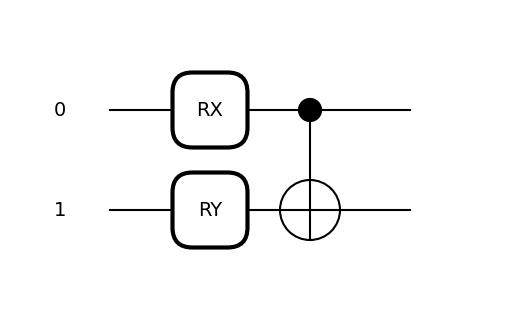

In [53]:
alpha = 0.4
beta = 0.2
coeffs = [alpha, alpha, beta]
# Define the ansatz
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
# H2 Hamiltonian from Yamamoto (2019)

obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

# Create Hamiltonian
H = qml.Hamiltonian(coeffs, obs_list)


# Define the full variational circuit QNode
@qml.qnode(dev)
def full_circuit(params):
    ansatz(params)
    return qml.expval(H)

# Generate random parameters
params = plnp.random.uniform(0, 2*plnp.pi, 2, requires_grad = True)

# Get the function for metric tensor computation
#This is the Firsher Information matirx
metric_tensor_fn = qml.metric_tensor(full_circuit)

# Optimization
max_iterations = 200
step_size = 0.05
conv_tol = 1e-06

# QNG
print('QUANTUM NATURAL GRADIENT DESCENT')
QNG_cost = []

# Initialization
prev_energy = full_circuit(params)

for n in range(max_iterations):
    # Calculate gradient
    gradient_fn = qml.grad(full_circuit, argnum=0)
    grad_at_point = gradient_fn(params)
    
    # Calculate the metric tensor
    metric_tensor_tuple = metric_tensor_fn(params)
    print(f"params is {params}")
    print(f"Tuple is {metric_tensor_tuple}")
    
    metric_tensor = metric_tensor_tuple

    print("Gradient at point shape:", plnp.shape(grad_at_point))
    print("Metric tensor shape:", plnp.shape(metric_tensor))

    eps = 1e-4  # Small constant to prevent singular matrix with determinant zero
    metric_tensor = metric_tensor + eps * plnp.identity(metric_tensor.shape[0])

    # Update rule
    if plnp.size(metric_tensor)!= 0:  # ensure that the metric tensor is not empty
        params = params - step_size * plnp.dot(plnp.linalg.inv(metric_tensor), grad_at_point)
    
    # Compute energy with new params
    energy = full_circuit(params)
    QNG_cost.append(energy)

    # Calculate the difference/ Convergence
    convergence = plnp.abs(energy - prev_energy)

    if convergence <= conv_tol:
        print('Found Ground State at step {:}'.format(n))
        print(("Ground-state Energy = ", energy))

    prev_energy = energy

print(qml.draw_mpl(ansatz)(params))
print(f"Hamiltonian is {H}")

# Expanding the Metric Tensor

In [28]:
!pip3 install pennylane-qiskit



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## Method 1 : Trying the qiskit to pennylane converter

In [48]:
import pennylane as qml

# Assuming the `circuit` is your Qiskit circuit

# Convert Qiskit circuit to a PennyLane template
ansatz = qml.from_qiskit(circuitQNG)




# Define the device
dev = qml.device('default.qubit', wires=8)

# Define the QNode
@qml.qnode(dev)
def full_circuit(params):
    ansatz(params, wires=range(8))
    return qml.expval(qml.PauliZ(0))  # Modify this as per the Hamiltonian or observable you are considering

# Now you can use full_circuit as your QNode in the PennyLane script.
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

# Create Hamiltonian
H = qml.Hamiltonian(coeffs, obs_list)
# Generate random parameters
params = plnp.random.uniform(0, 2*plnp.pi, 71, requires_grad = True)

# Get the function for metric tensor computation
#This is the Firsher Information matirx
metric_tensor_fn = qml.metric_tensor(full_circuit)

# Optimization
max_iterations = 200
step_size = 0.05
conv_tol = 1e-06

# QNG
print('QUANTUM NATURAL GRADIENT DESCENT')
QNG_cost = []

# Initialization
prev_energy = full_circuit(params)

for n in range(max_iterations):
    # Calculate gradient
    gradient_fn = qml.grad(full_circuit, argnum=0)
    grad_at_point = gradient_fn(params)
    
    # Calculate the metric tensor
    metric_tensor_tuple = metric_tensor_fn(params)
    print(f"params is {params}")
    print(f"Tuple is {metric_tensor_tuple}")
    
    metric_tensor = metric_tensor_tuple

    print("Gradient at point shape:", plnp.shape(grad_at_point))
    print("Metric tensor shape:", plnp.shape(metric_tensor))

    eps = 1e-4  # Small constant to prevent singular matrix with determinant zero
    metric_tensor = metric_tensor + eps * plnp.identity(metric_tensor.shape[0])

    # Update rule
    if plnp.size(metric_tensor)!= 0:  # ensure that the metric tensor is not empty
        params = params - step_size * plnp.dot(plnp.linalg.inv(metric_tensor), grad_at_point)
    
    # Compute energy with new params
    energy = full_circuit(params)
    QNG_cost.append(energy)

    # Calculate the difference/ Convergence
    convergence = plnp.abs(energy - prev_energy)

    if convergence <= conv_tol:
        print('Found Ground State at step {:}'.format(n))
        print(("Ground-state Energy = ", energy))

    prev_energy = energy


QUANTUM NATURAL GRADIENT DESCENT


AttributeError: 'tensor' object has no attribute 'items'

## Method 2: Converting our qiskit implementation to pennylane

In [42]:
import pennylane as qml
import numpy as np

# defining the custom gate operations

# defining the custom gate operations

def CRZ(params, wires):
    qml.CRot(params, 0, 0, wires=wires)
    
def CRX(params, wires):
    qml.CRot(0, params, 0, wires=wires)

# define the ansatz
def ansatz(params, wires):
    for i in range(len(params)):
        qml.RX(params[i], wires=i)
        
    CRZ(np.pi / 2, wires=[1, 0])
    CRX(np.pi / 2, wires=[1, 0])
    CRZ(np.pi/2, wires=[3, 2]) 
    CRX(np.pi/2, wires=[3, 2])
    CRZ(np.pi/2, wires=[2, 0])
    CRX(np.pi/2, wires=[2, 0])

# define the pooling circuit
def pooling_circuit(params, wires):
    qml.RZ(-np.pi / 2, wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RZ(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RY(params[2], wires=wires[1])

# creating the ansatz layers
def conv_layer(num_qubits, params):
    for i in range(num_qubits):
        ansatz(params, wires=i)
    
# creating the pooling layers
def pool_layer(sources, sinks, params):
    for s, t in zip(sources, sinks):
        pooling_circuit(params, wires=[s, t])

    
# create the feature map
num_qubits = 8
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def circuitQML(params, inputs=None):
    #AngleEmbedding is pennylane's version of feature map. It encodes the classical data into a quantum state.
    #inputs represent the real data.
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    
    # First Convolutional Layer
    conv_layer(num_qubits, params[:num_qubits])
    
    # First Pooling Layer
    pool_layer(range(0, num_qubits - 3, 2), range(4, num_qubits - 3, 2), params[num_qubits:num_qubits+6])
    
    # Second Convolutional Layer
    conv_layer(num_qubits//2, params[num_qubits+6:num_qubits+10])
    
    # Second Pooling Layer
    pool_layer(range(0, num_qubits//2 - 1, 2), range(2, num_qubits//2 - 1, 2), params[num_qubits+10:num_qubits+13])
    
    # Third Convolutional Layer
    conv_layer(num_qubits//4, params[num_qubits+13:num_qubits+15])
    
    # Third Pooling Layer
    pool_layer([0], [1], params[num_qubits+15:num_qubits+18])
    
    
    return qml.expval(qml.PauliZ(0))


(<Figure size 8600x900 with 1 Axes>, <Axes: >)
<QNode: wires=8, device='default.qubit.autograd', interface='auto', diff_method='best'>


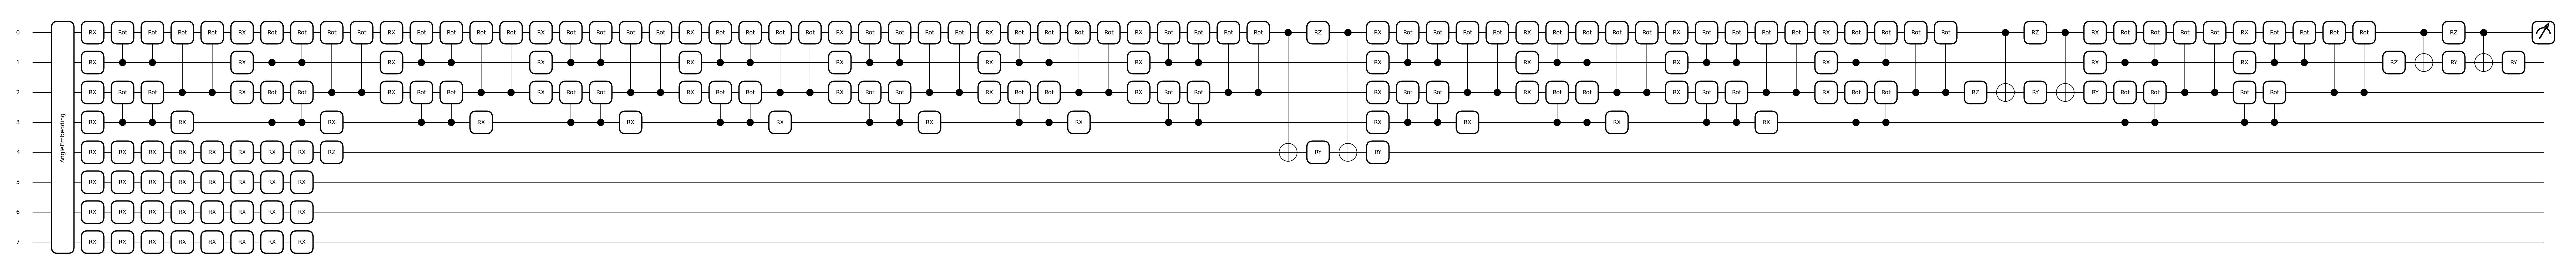

In [43]:
params = np.random.uniform(0,2*pi,26)
inputs = np.random.uniform(0,2*np.pi,8)
mycirc = circuitQML(params,inputs)
print(qml.draw_mpl(circuitQML)(params,inputs))
print(circuitQML)

In [ ]:
import pennylane as qml
from pennylane import numpy as plnp
from pennylane.optimize import GradientDescentOptimizer

# Use your defined circuit
@qml.qnode(dev)
def full_circuit(params, inputs=None):
    circuitQML(params, inputs)
    return qml.expval(qml.H)

opt = GradientDescentOptimizer(stepsize=0.05)

print('QUANTUM NATURAL GRADIENT DESCENT')

# Get the function for metric tensor computation
metric_tensor_fn = qml.metric_tensor(full_circuit)

for i in range(200):
    # Compute the metric tensor
    metric_tensor = metric_tensor_fn(params, inputs)
    
    # Perform an optimization step
    params, prev_energy = opt.step_and_cost(full_circuit, params, args=[inputs], metric_tensor_fn=metric_tensor)
    
    # Compute the energy at the new parameter values
    energy = full_circuit(params, inputs)
    
    # Print current energy
    print(f"Step {i}, Energy: {energy}")
    
    # Check for convergence
    if np.abs(energy - prev_energy) < 1e-6:
        break

print(f"Optimized parameters: {params}")
print(f"Minimum energy: {energy}")


QUANTUM NATURAL GRADIENT DESCENT


/opt/homebrew/lib/python3.10/site-packages/pennylane/transforms/metric_tensor.py:417: UserWarning: Attempted to compute the metric tensor of a QNode with no trainable parameters. If this is unintended, please add trainable parameters in accordance with the chosen auto differentiation framework.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/pennylane/_grad.py:112: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


TypeError: full_circuit() got an unexpected keyword argument 'args'

## Method 3: Implementing the Fubini Metric tensor and autograd in Qiskit

In [143]:
#Define the ansatz in Qiskit
#Define the params
from qiskit.quantum_info import Operator
from qiskit import Aer, execute
from qiskit.opflow import Gradient

def expectation_value(circuit, operator):
    #if circuit in ZI or IZ, no need to change basis since 0 and 1 are eigen vlaues of Z
    if operator == 'ZI' or operator == 'IZ':
        pass
    elif operator == 'XX' :
        #Apply the hadamard gate to change the basis since X gate has eigen values of + and - and not 0 and 1
        circuit.h([0,1])
    circuit.measure_all()
    
    #define the backend
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots = 1000)
    result = job.result()
    counts = result.get_counts(circuit)

    #Compute the expectation value
    #Expectation value has + for 00 and 11 in the Z basis 
    #Expectaiton value has - for 01 and 10 in the Z basis
    #This is because in the operator ZZ acting on 2 qubits, if one of them is 1 state, then Z operator acting on it returns -1 as eigen value

    expectation = counts.get('00',0) + counts.get('11',0) - counts.get('10',0) - counts.get('01',0)/1000
    return expectation

params = np.random.uniform(0,2*np.pi,2)
def ansatz(params, qisTarget):
    #qisTarget = QuantumCircuit(2)
    qisTarget.rx(params[0],0)
    qisTarget.ry(params[1],1)
    qisTarget.cnot(0,1)

#Observation list in qiskit
pauliZ = Operator([[1,0],[0,-1]])
identityOp = Operator([[1,0],[0,1]])
pauliX = Operator([[0,1],[1,0]])
obs_list_qiskit = [pauliZ.tensor(identityOp), identityOp.tensor(pauliZ), pauliX.tensor(pauliX)] 

coeffs = [0.4,0.4,0.2]

#create hamiltonian
hamiltonianQiskit = Operator(np.zeros((4, 4)))
for i in range(len(coeffs)):
    hamiltonianQiskit+= coeffs[i]* obs_list_qiskit[i]

print(hamiltonianQiskit)
#After successfully creating the hamiltonian, move on to next steps

def full_circuit(params):
    #Redefning the code for the ansatz.
    qisTarget = QuantumCircuit(2)
    ansatz(params, qisTarget)
   #qisTarget.rx(params[0],0)
    #qisTarget.ry(params[1],1)
    #qisTarget.cnot(0,1)
    total_exp_value = 0
    operators = ['ZI','IZ','XX']

    for coeff, op in zip(coeffs, operators):
        #create a copy of the circuit
        circuit = qisTarget.copy()
        exp_value = expectation_value(circuit, op)
        #This addition essentially encapsulates the hamiltonian
        total_exp_value += coeff * exp_value

    return total_exp_value

print(f"Total Expectation value is {full_circuit(params)}")

#Implementing the metric tensor function in Qiskit

    

Operator([[ 0.8+0.j,  0. +0.j,  0. +0.j,  0.2+0.j],
          [ 0. +0.j,  0. +0.j,  0.2+0.j,  0. +0.j],
          [ 0. +0.j,  0.2+0.j,  0. +0.j,  0. +0.j],
          [ 0.2+0.j,  0. +0.j,  0. +0.j, -0.8+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Total Expectation value is 813.1512


## Testing the Metric Tensor

In [ ]:
import pennylane.numpy as np
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="autograd")
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[2], wires=1)
    qml.RZ(weights[3], wires=0)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(qml.PauliY(1))

mt_fn = qml.metric_tensor(circuit)
weights = np.array([0.1, 0.2, 0.4, 0.5], requires_grad=True)
mt_fn(weights)

tensor([[ 0.25      ,  0.        , -0.04966733, -0.04966733],
        [ 0.        ,  0.24750832,  0.02433865,  0.02433865],
        [-0.04966733,  0.02433865,  0.01226071,  0.01226071],
        [-0.04966733,  0.02433865,  0.01226071,  0.01226071]], requires_grad=True)

## Testing the Model 

In [ ]:

x = np.asarray(test_images)
y = np.asarray(test_labels)
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert to numpy arrays
x_train = np.asarray(train_images)
y_train = np.asarray(train_labels)
x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x_train,y_train)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

ValueError: too many values to unpack (expected 2)

In [ ]:
print(len(y))

45


Accuracy from the test data : 71.43%


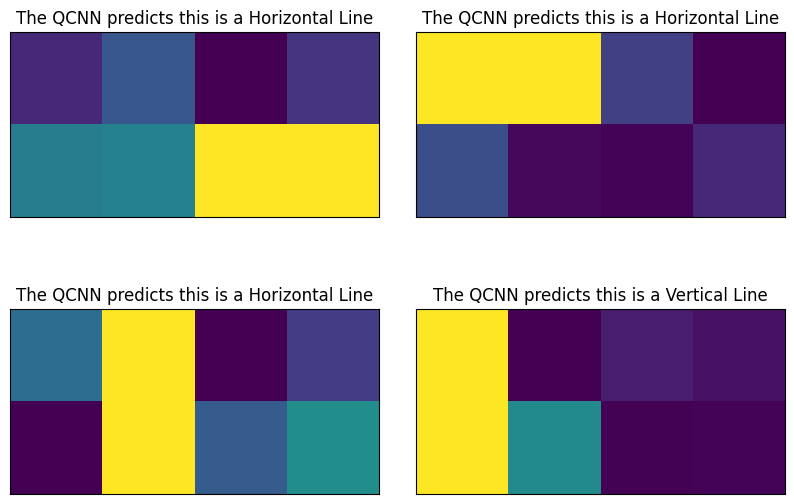

In [ ]:

y_predict = classifier.predict(test_images)
x = np.asarray(train_images)
y = np.asarray(train_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
print(len(y))

350
